In [1]:
import os
os.environ['MKL_ENABLE_INSTRUCTIONS'] = 'SSE4_2'
import warnings
warnings.filterwarnings("ignore", message="Intel MKL WARNING*")
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from lightgbm import LGBMRegressor
import lightgbm
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import RandomizedSearchCV
import plotly.express as px
from scipy import stats
import ta
# import numba
from scipy.fft import fft
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
# Constants
returnInterval = 12  # 1 hr
rolling_window = 24 * 7 * returnInterval  # 1 week
forecast_period = 24 * returnInterval  # 1 day

In [3]:
def rolling_linear_regression(X, y, window_size):
    X_roll_sum = X.rolling(window=window_size, min_periods=1).sum()
    y_roll_sum = y.rolling(window=window_size, min_periods=1).sum()
    X2_roll_sum = (X ** 2).rolling(window=window_size, min_periods=1).sum()
    Xy_roll_sum = (X * y).rolling(window=window_size, min_periods=1).sum()

    # Compute beta (slope of regression line) for each window
    beta = (Xy_roll_sum - (X_roll_sum * y_roll_sum) / window_size) / (X2_roll_sum - (X_roll_sum ** 2) / window_size)
    
    # # Fill NaNs in beta with 0 to avoid issues at the beginning
    # beta = beta.fillna(0)

    return beta

In [ ]:
# window_size = 2016 #One week of indexes

btc_df = pd.read_parquet("data/BTCUSDT.pq")
btc_df = btc_df.sort_values(by = "time")
btc_df["return"] = btc_df["close"] - btc_df["close"].shift(returnInterval)
btc_df = btc_df.dropna()
# btc_df["return"] = np.log(btc_df['close']/btc_df['close'].shift(1))
# btc_df = btc_df.drop(btc_df.index[0])
btc_df.reset_index(inplace=True)

if not os.path.exists("market_neutral/"):
    os.mkdir("market_neutral/")

for filename in os.listdir("data/"):
    if filename.endswith(".pq") and filename != "BTCUSDT.pq":
        print(filename)
        x_df = pd.read_parquet(os.path.join("data/", filename))
        x_df = x_df.sort_values(by = "time")
        x_df["return"] = x_df["close"] - x_df["close"].shift(returnInterval)
        x_df = x_df.dropna()

        if (x_df.shape[0] != btc_df.shape[0]) or (not all(btc_df.time.values == x_df.time.values)):
            print(f"Times dont add up for file {filename}", x_df.shape[0], btc_df.shape[0])
            continue
        
        X = btc_df["return"]
        y = x_df["return"]

        beta = rolling_linear_regression(X, y, rolling_window)

        # X = btc_df["return"].values.reshape(-1, 1)
        # y = x_df["return"].values

        # model = LinearRegression().fit(X, y)
        # beta = model.coef_[0]

        MN_x = x_df.copy()
        columns = ["return"]
        MN_x["mn_return"] = x_df["return"] - beta * btc_df["return"]
        MN_x["mn_close"] = x_df["close"] - beta * btc_df["close"]
        MN_x["mn_open"] = x_df["open"] - beta * btc_df["open"]
        MN_x["mn_high"] = x_df["high"] - beta * btc_df["high"]
        MN_x["mn_low"] = x_df["low"] - beta * btc_df["low"]
        MN_x = MN_x.loc[:,["time", "close", "mn_close", "mn_open", "mn_high", "mn_low", "mn_return", "volume", "turnover"]] #makes above line a little reundant
        MN_x.reset_index(drop=True, inplace=True)
        
        MN_x.to_parquet(f"market_neutral/MN_{filename[:-3]}.pq")

In [5]:
def analyze_lags(selected_coins, lag_periods, data_path='market_neutral/'):
    # Function to load data and prepare it
    def load_and_prepare_data(coin):
        df = pd.read_parquet(os.path.join(data_path, coin))
        df['mn_return'] = df['mn_return'].astype(float)  # Ensure return is float
        return df[['time', 'mn_return']]

    # Function to calculate lagged returns
    def calculate_lags(df, lags):
        for lag in lags:
            df[f'lag_return_{lag}h'] = df['mn_return'].shift(lag)
        return df.dropna()  # Drop NaN values after shifting

    # Store results in a dictionary
    results = {}

    # Load data for all coins in the market_neutral folder only once
    all_coins_data = {}
    for file in os.listdir(data_path):
        if file.endswith('.pq'):
            coin_name = file
            all_coins_data[coin_name] = load_and_prepare_data(coin_name)

    for coin in selected_coins:
        all_coins_data = {}
        for file in os.listdir(data_path):
            if file.endswith('.pq'):
                coin_name = file
                all_coins_data[coin_name] = load_and_prepare_data(coin_name)
        current_df = all_coins_data[coin]
        print(coin)
        # Prepare to store t-stats for regressions
        t_stats = []
        
        # Loop through all other coins (not selected ones)
        for other_coin, other_df in all_coins_data.items():
            if other_coin != coin:
                # Calculate lags for the other cryptocurrency
                other_df_lagged = calculate_lags(other_df, lag_periods)
                
                # Truncate current_df to match lengths after lagging
                min_length = min(len(current_df), len(other_df_lagged))
                current_df_truncated = current_df.iloc[-min_length:].reset_index(drop=True)
                other_df_truncated = other_df_lagged.iloc[-min_length:].reset_index(drop=True)
                
                # Merge dataframes on time index
                merged_df = current_df_truncated.merge(
                    other_df_truncated,
                    on='time',
                    suffixes=('', '_other')
                )
                
                # Test each lag separately
                for lag in lag_periods:
                    X = merged_df[[f'lag_return_{lag}h']].dropna()
                    y = merged_df['mn_return'].iloc[X.index].dropna()
                    
                    if len(X) > 0 and len(y) > 0:
                        # Perform Linear Regression
                        model = LinearRegression()
                        model.fit(X, y)
                        
                        # Calculate t-statistics for coefficients
                        residuals = y - model.predict(X)
                        s_squared = np.sum(residuals**2) / (len(y) - X.shape[1])
                        std_errs = np.sqrt(s_squared * np.linalg.inv(np.dot(X.T, X)).diagonal())
                        
                        t_stat_values = model.coef_ / std_errs

                        # Calculate correlation coefficient
                        correlation_matrix = np.corrcoef(X.values.flatten(), y)
                        correlation_value = correlation_matrix[0, 1]  # Extract the correlation value

                        # Store the t-statistic with coin name, lag value, and correlation value
                        for t_stat in t_stat_values:
                            t_stats.append((other_coin, t_stat, lag, correlation_value))
        
        # Sort by absolute value of t-statistics and get top 10
        top_t_stats = sorted(t_stats, key=lambda x: abs(x[1]), reverse=True)[:10]
        
        results[coin] = top_t_stats

    return results

# Example usage:
selected_coins_list = [
    "MN_RSRUSDT.pq", "MN_VRAUSDT.pq", "MN_SILLYUSDT.pq", "MN_AUCTIONUSDT.pq", "MN_BLZUSDT.pq",
    "MN_PENDLEUSDT.pq", "MN_BLURUSDT.pq"
]

lag_periods_list = [12, 72, 144, 288]  # Example lag periods (1 hours, 24 hours, etc.)

# Call the function and get results
results_dict = analyze_lags(selected_coins_list, lag_periods_list)

# Display results
for coin, stat in results_dict.items():
    print(f"{coin}: {stat}")

MN_RSRUSDT.pq
MN_VRAUSDT.pq
MN_SILLYUSDT.pq
MN_AUCTIONUSDT.pq
MN_BLZUSDT.pq
MN_PENDLEUSDT.pq
MN_BLURUSDT.pq
MN_RSRUSDT.pq: [('MN_TRUUSDT.pq', np.float64(-12.352808282597596), 288, np.float64(-0.06603216273887275)), ('MN_HIGHUSDT.pq', np.float64(-10.328650000862806), 288, np.float64(-0.05520755405274433)), ('MN_CETUSUSDT.pq', np.float64(-10.324400162670468), 288, np.float64(-0.05521837526632972)), ('MN_CROUSDT.pq', np.float64(-10.303397972401141), 288, np.float64(-0.05511195670685316)), ('MN_CFXUSDT.pq', np.float64(-9.959722315948547), 288, np.float64(-0.0532850065981963)), ('MN_ARBPERP.pq', np.float64(-9.754046339778748), 288, np.float64(-0.05217073634178919)), ('MN_AEVOUSDT.pq', np.float64(-9.738319203837627), 12, np.float64(-0.05208584038807266)), ('MN_ARPAUSDT.pq', np.float64(-9.728360726005501), 288, np.float64(-0.05203586708490031)), ('MN_ARBUSDT.pq', np.float64(-9.708134925470615), 288, np.float64(-0.05192511269971729)), ('MN_CELRUSDT.pq', np.float64(-9.6871513381762), 288, np.fl

In [ ]:
df_dict = {}
for key in results_dict.keys():
    mn_df = pd.read_parquet(f'market_neutral/{key}')
    mn_df.set_index("time", inplace=True)

    # Loop through each entry in results_dict for MN_ALPHAUSDT
    for coin_name, t_stat, lag, correlation in results_dict[key]:
        # Load the other coin's DataFrame
        other_df = pd.read_parquet(f"market_neutral/{coin_name}")
        other_df.set_index("time", inplace=True)
        
        # Lag the 'mn_close' column by the specified number of rows
        other_df[f'{coin_name}_lagged_return_{lag}'] = other_df['mn_return'].shift(lag)
        
        # Merge the lagged values back into mn_df
        mn_df = mn_df.merge(other_df[[f'{coin_name}_lagged_return_{lag}']], left_index=True, right_index=True, how='left')
    
    mn_df["y"] = (mn_df["mn_close"].shift(-returnInterval)-mn_df["mn_close"])/np.abs(mn_df["mn_close"])
    # mn_df["y"] = mn_df["mn_return"].shift(-returnInterval)
    mn_df = mn_df.dropna()
    print((mn_df))
    # Display the updated mn_df with lagged values
    df_dict[key] = mn_df.copy()
    # mn_silly.drop(columns=["turnover"], inplace=True)

# print(df_dict)

In [7]:
def generate_features(df):
    # Ensure the dataframe is sorted by time
    
    # The mn_return column already contains 1-hour returns
    # df['log_return'] = np.log(df['mn_close']/df["mn_close"].shift(1))  # Adding 1 to handle negative returns
    # print("done")
    # Custom moving averages and related features
    for window in [5, 10, 20, 50, 100]:
        df[f'sma_{window}h'] = df['mn_return'].rolling(window=window*returnInterval).mean()
        df[f'ema_{window}h'] = df['mn_return'].ewm(span=window*returnInterval, adjust=False).mean()
        df[f'return_ma_{window}h'] = df['mn_return'].rolling(window=window*returnInterval).mean()
        df[f'return_std_{window}h'] = df['mn_return'].rolling(window=window*returnInterval).std()
        df[f'z_score_{window}h'] = (df['mn_close'] - df[f'sma_{window}h']) / df['mn_close'].rolling(window=window*returnInterval).std()
    # print("done")
    # Price momentum
    for lag in [1, 5, 10, 20]:
        df[f'momentum_{lag}h'] = df['mn_close'].pct_change(lag*returnInterval)
    # print("done")
    # Return autocorrelation

    # @numba.jit(nopython=True)
    # def autocorr(x, lag):
    #     return np.correlate(x[lag:] - x[lag:].mean(), x[:-lag] - x[:-lag].mean())[0] / (np.std(x[lag:]) * np.std(x[:-lag]) * len(x[lag:]))

    # def rolling_autocorr(series, window, lag):
    #     return series.rolling(window=window).apply(lambda x: autocorr(x, lag), raw=True, engine='numba')

    # In your generate_features function:
    # for lag in [1, 5, 10, 20]:
    #     df[f'return_autocorr_{lag}h'] = rolling_autocorr(df['mn_return'], lag*returnInterval*2, lag*returnInterval)
    # print("done")
    # Volatility measures
    df['volatility_4h'] = df['mn_return'].rolling(window=returnInterval*4).std()
    df['volatility_1d'] = df['mn_return'].rolling(window=returnInterval*24).std()
    df['volatility_1w'] = df['mn_return'].rolling(window=returnInterval*24*7).std()
    # print("done")
    # Range-based features
    df['daily_range'] = df['mn_close'].rolling(window=returnInterval*24).max() - df['mn_close'].rolling(window=returnInterval*24).min()
    df['price_range_percentile'] = (df['mn_close'] - df['mn_close'].rolling(window=returnInterval*24).min()) / df['daily_range']
    # print("done")
    # RSI
    df['rsi'] = ta.momentum.RSIIndicator(df['mn_close'], window=returnInterval*24).rsi()
    # print("done")
    # MACD
    macd = ta.trend.MACD(df['mn_close'], window_slow=26*returnInterval, window_fast=12*returnInterval, window_sign=9*returnInterval)
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_diff'] = macd.macd_diff()
    # print("done")
    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(df['mn_close'], window=20*60)
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    df['bb_pct'] = (df['mn_close'] - df['bb_low']) / (df['bb_high'] - df['bb_low'])
    # print("done")
    # Transformed features
    df['rank_price'] = df['mn_close'].rank(pct=True)
    df['ts_rank_price_1d'] = df['mn_close'].rolling(window=returnInterval).apply(lambda x: stats.percentileofscore(x, x.iloc[-1]))
    df['price_change_rate'] = df['mn_close'].pct_change(returnInterval)  # 1-hour change rate
    # print("done")
    # Volume-based features
    df['volume_ma_1d'] = df['volume'].rolling(window=returnInterval*24).mean()
    df['volume_ma_1w'] = df['volume'].rolling(window=returnInterval*24*7).mean()
    df['relative_volume'] = df['volume'] / df['volume_ma_1d']
    # print("done")
    # Turnover-based features
    df['turnover_ma_1d'] = df['turnover'].rolling(window=returnInterval*24).mean()
    df['turnover_ma_1w'] = df['turnover'].rolling(window=returnInterval*24*7).mean()
    df['relative_turnover'] = df['turnover'] / df['turnover_ma_1d']
    print("done")
    # Fourier transforms for cyclical patterns
    # def fourier_transform(x, num_components=3):
    #     if len(x) == 0:
    #         return np.nan
    #     f = fft(x)
    #     f_abs = np.abs(f)
    #     indices = np.argsort(f_abs)[::-1][:num_components]
    #     return np.sum(f_abs[indices])  # Return the sum of the magnitudes of the top components

    # # In your generate_features function:
    # df['fourier_7d'] = df['mn_close'].rolling(window=returnInterval*24*7).apply(fourier_transform, raw=True)
    # print("done")
    # # Fractal dimension
    # def hurst_exponent(x):
    #     lags = range(2 * returnInterval, 100 * returnInterval, returnInterval)
    #     tau = [np.sqrt(np.std(np.subtract(x[lag:], x[:-lag]))) for lag in lags]
    #     poly = np.polyfit(np.log(lags), np.log(tau), 1)
    #     return poly[0] * 2.0
    
    # df['hurst_exponent'] = df['mn_close'].rolling(window=returnInterval*24).apply(hurst_exponent)
    
    # Cross-sectional neutralization (assuming you have multiple assets)
    # This would typically be done across assets, but as an example:
    # df['cs_neutral_price'] = df['mn_close'] - df['mn_close'].rolling(window=1440).mean()
    df = df.dropna()
    return df

for key in df_dict.keys():
    print(key)
    df_dict[key] = generate_features(df_dict[key])
    # print(df_dict[key].columns)

MN_RSRUSDT.pq
done
MN_VRAUSDT.pq
done
MN_SILLYUSDT.pq
done
MN_AUCTIONUSDT.pq
done
MN_BLZUSDT.pq
done
MN_PENDLEUSDT.pq
done
MN_BLURUSDT.pq
done


In [24]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeRegressor

def select_top_features_fast(df_dict_new, target_col='y', n_features=10):
    for key, df in df_dict_new.items():
        # print(df_dict_new[key].columns)
        print(f"Selecting features for {key}")
        
        # Separate features and target
        X = df.drop(columns=[target_col])
        y = df[target_col]
        
        # Remove low variance features
        selector = VarianceThreshold(threshold=0.01)
        X_selected = selector.fit_transform(X)
        selected_features = X.columns[selector.get_support()].tolist()
        
        # If we have more than n_features after variance thresholding, use DecisionTree importance
        if len(selected_features) > n_features:
            X_reduced = X[selected_features]
            tree = DecisionTreeRegressor(max_depth=5, random_state=42)
            tree.fit(X_reduced, y)
            importances = pd.Series(tree.feature_importances_, index=X_reduced.columns)
            selected_features = importances.nlargest(n_features).index.tolist()
        
        # Update dataframe with selected features and target
        df_dict_new[key] = df[selected_features + [target_col]]
        
        print(f"Selected features for {key}: {selected_features}")
    
    return df_dict_new

# Apply fast feature selection to df_dict
df_dict_new = select_top_features_fast(df_dict)


Selecting features for MN_RSRUSDT.pq
Selected features for MN_RSRUSDT.pq: ['z_score_5h', 'z_score_10h', 'volume_ma_1w', 'z_score_20h', 'z_score_50h', 'turnover_ma_1d', 'rsi', 'turnover_ma_1w', 'momentum_20h', 'momentum_5h']
Selecting features for MN_VRAUSDT.pq
Selected features for MN_VRAUSDT.pq: ['z_score_20h', 'z_score_5h', 'z_score_10h', 'MN_ZECUSDT.pq_lagged_return_288', 'z_score_50h', 'rank_price', 'momentum_10h', 'rsi', 'turnover_ma_1d', 'turnover_ma_1w']
Selecting features for MN_SILLYUSDT.pq
Selected features for MN_SILLYUSDT.pq: ['momentum_1h', 'z_score_5h', 'price_change_rate', 'momentum_10h', 'z_score_10h', 'z_score_20h', 'turnover_ma_1w', 'rank_price', 'relative_turnover', 'turnover_ma_1d']
Selecting features for MN_AUCTIONUSDT.pq
Selected features for MN_AUCTIONUSDT.pq: ['z_score_5h', 'z_score_20h', 'ts_rank_price_1d', 'bb_low', 'z_score_10h', 'momentum_5h', 'macd', 'macd_diff', 'z_score_50h', 'macd_signal']
Selecting features for MN_BLZUSDT.pq
Selected features for MN_BLZ

In [ ]:
# for key in df_dict.keys():
#     print(df_dict[key])


colsrsr = ["close", "mn_close", "mn_return", "volume", "turnover", 'z_score_5h', 'z_score_10h', 'volume_ma_1w', 'y']
colssilly = ["close", "mn_close", "mn_return", "volume", "turnover", 'momentum_1h', 'z_score_5h', 'price_change_rate', 'y']
df_dict_small = {}
df_dict_small["MN_RSRUSDT.pq"] = df_dict["MN_RSRUSDT.pq"].copy()
df_dict_small["MN_RSRUSDT.pq"] = df_dict_small["MN_RSRUSDT.pq"][colsrsr]
df_dict_small["MN_SILLYUSDT.pq"] = df_dict["MN_SILLYUSDT.pq"].copy()
df_dict_small["MN_SILLYUSDT.pq"] = df_dict_small["MN_SILLYUSDT.pq"][colssilly]

print(df_dict_small)

MN_RSRUSDT.pq
8629
bounds -0.17229584953350086 0.1435096427680522
MN_RSRUSDT.pq [ 1.09054276e-01  8.21365200e+00  4.83706408e-10 -7.89416724e-08
  2.09604051e-06  7.27716127e-06  2.43715537e-09 -1.33826159e-05
  8.74364860e-06 -3.67603100e-08  4.79860853e-04 -3.73549353e-07
 -2.12797312e-02 -3.74995412e-03]

Summary statistics for MN_RSRUSDT.pq:
y_test:
count    8629.000000
mean        0.007611
std         0.103015
min        -0.776827
25%        -0.008399
50%         0.000949
75%         0.010709
max         2.041692
Name: y, dtype: float64

y_pred:
count    8629.000000
mean       -0.001414
std         0.008399
min        -0.116845
25%        -0.001457
50%        -0.000255
75%         0.000629
max         0.010318
dtype: float64
LGBM Train R2: 0.0596622618583581
LGBM Test R2: -63.46076200028894
Linear Train R2: -105.49051779133934
Linear Test R2: -153.8196174474391
MN_SILLYUSDT.pq
8629


/Users/niteesh/opt/anaconda3/envs/tradingEnv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


bounds -58.06026477705158 34.01039824653577
MN_SILLYUSDT.pq [ 2.40594964e+00 -1.27056341e+01  8.85393980e-09 -5.85825529e-07
 -1.52173767e-03  2.64957891e-06 -1.52174461e-03 -2.04243229e-03
  5.15527992e-05 -4.21148811e-05  7.81932572e-07 -4.03676285e-02
  1.29765437e-03 -2.45440142e-07]

Summary statistics for MN_SILLYUSDT.pq:
y_test:
count    8629.000000
mean        0.005701
std         0.078319
min        -0.391597
25%        -0.013463
50%         0.001128
75%         0.016218
max         1.384375
Name: y, dtype: float64

y_pred:
count    8629.000000
mean       -0.001165
std         0.011834
min        -0.034142
25%        -0.007694
50%        -0.001574
75%         0.005001
max         0.297021
dtype: float64
LGBM Train R2: -0.7571865972042882
LGBM Test R2: -0.4629826968566537
Linear Train R2: -1796.3954892083088
Linear Test R2: -44.44791279250094
[DatetimeIndex(['2024-09-01 00:00:00', '2024-09-01 00:05:00',
               '2024-09-01 00:10:00', '2024-09-01 00:15:00',
              

/Users/niteesh/opt/anaconda3/envs/tradingEnv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/var/folders/3b/0jn7ny8n0792y6v1yr47g2m40000gn/T/ipykernel_1599/861989788.py:36: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(mse * (1 + 1/n + x @ cov_matrix @ x.T))


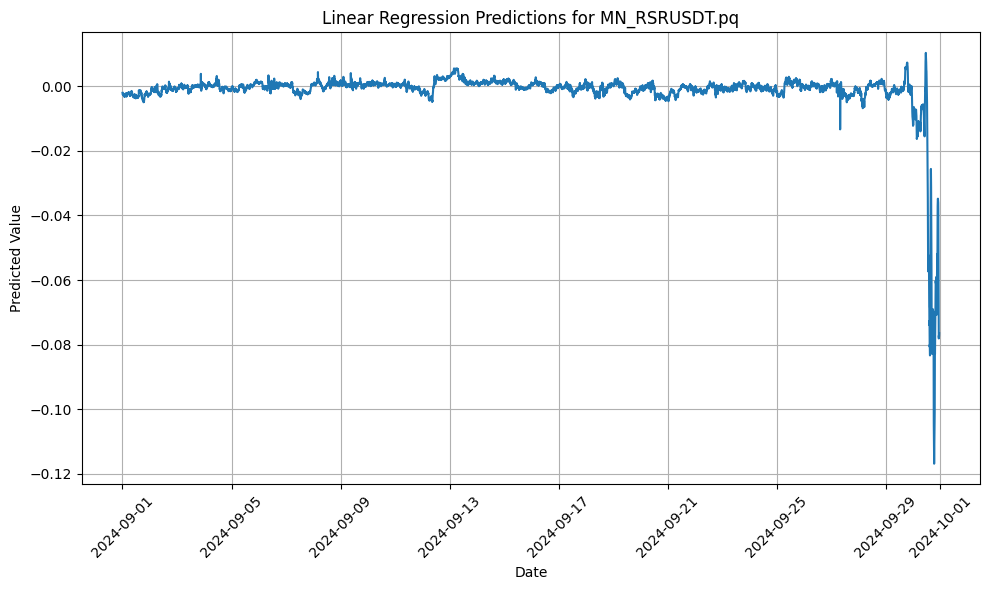

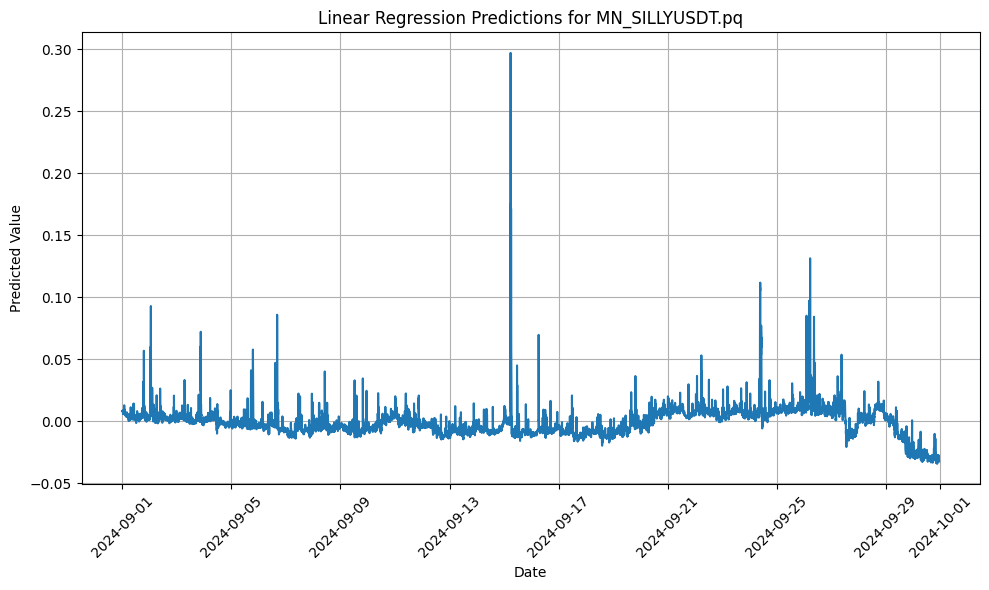

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

train_time = pd.to_datetime("09/01/24")
predictions_lgbm = {}
predictions_linear = {}
confidences_linear = {}  # New dictionary for linear regression confidences
times = []

def calculate_se_pred(X_train, X_test, linear_model, y_train):
    # Ensure inputs are numpy arrays
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train).ravel()

    n, p = X_train.shape

    # Calculate MSE
    y_pred_train = linear_model.predict(X_train)
    residuals = y_train - y_pred_train
    mse = np.mean(residuals**2)

    # Calculate the variance-covariance matrix of the coefficients
    X_mean = np.mean(X_train, axis=0)
    X_centered = X_train - X_mean
    try:
        cov_matrix = np.linalg.inv(X_centered.T @ X_centered)
    except np.linalg.LinAlgError:
        # Use pseudo-inverse if regular inverse fails
        cov_matrix = np.linalg.pinv(X_centered.T @ X_centered)

    # Calculate standard error for each prediction
    X_test_centered = X_test - X_mean
    se_pred = []
    for x in X_test_centered:
        se = np.sqrt(mse * (1 + 1/n + x @ cov_matrix @ x.T))
        se_pred.append(se)

    return np.array(se_pred)
track = 0
for key, mn_df in df_dict_small.items():
    track += 1
    X = mn_df
    print(key)
    X = X.drop(columns="mn_close")
    X_train = X[X.index < train_time]
    y_train = X_train["y"]
    X_train = X_train.drop(columns=["y"])
    X_test = X[X.index >= train_time]
    y_test = X_test["y"]
    X_test = X_test.drop(columns=["y"])
    print(len(X_test))
    y_train_min = min(y_train)
    y_train_max = max(y_train)
    print("bounds", y_train_min, y_train_max)

    # LGBM model
    params = {"verbose":-1}
    lgbm_model = LGBMRegressor(**params)
    lgbm_model.fit(X_train, y_train)
    y_pred_train_lgbm = lgbm_model.predict(X_train)
    y_pred_test_lgbm = lgbm_model.predict(X_test)
    times.append(X_test.index)
    predictions_lgbm[key] = y_pred_test_lgbm

    # Linear model
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    print(key, linear_model.coef_)
    y_pred_train_linear = linear_model.predict(X_train)
    y_pred_test_linear = linear_model.predict(X_test)
    for i in range (len(y_pred_test_linear)):
        if y_pred_test_linear[i] < y_train_min or y_pred_test_linear[i] > y_train_max:
            y_pred_test_linear[i] = 0
    predictions_linear[key] = y_pred_test_linear
    # plt.figure(figsize=(10, 6))
    # plt.scatter(y_test, y_pred_test_linear, alpha=0.6, color='blue', label='Predictions')
    # plt.title(f'Linear Regression Predictions vs Actual for {key}')
    # plt.xlabel('Actual Values')
    # plt.ylabel('Predicted Values')
    # plt.legend()
    # plt.grid()
    # plt.show()

     # Plot distribution of y_pred and y_test for Linear Regression
    # if track == 1:
    #     plt.figure(figsize=(12, 6))
    #     sns.histplot(y_test, kde=True, color='blue', label='y_test', alpha=0.5)
    #     sns.histplot(y_pred_test_linear, kde=True, color='red', label='y_pred', alpha=0.5)
    #     plt.title(f'Distribution of y_test and y_pred for {key}')
    #     plt.legend(loc='upper right')
    #     plt.show()

     # Print summary statistics for Linear Regression predictions
    print(f"\nSummary statistics for {key}:")
    print("y_test:")
    print(y_test.describe())
    
    print("\ny_pred:")
    print(pd.Series(y_pred_test_linear).describe())

    # Calculate confidence for linear regression predictions
    mse = mean_squared_error(y_train, y_pred_train_linear)
    se_pred = calculate_se_pred(X_train, X_test, linear_model, mse)

    # Convert standard error to confidence (1 / se_pred)
    confidence = 1 / se_pred

    # Handle NaN values
    confidence = np.nan_to_num(confidence, nan=np.nanmedian(confidence))

    # Normalize confidence values to be between 0 and 1
    confidence_min = np.min(confidence)
    confidence_max = np.max(confidence)
    if confidence_max > confidence_min:
        confidence_normalized = (confidence - confidence_min) / (confidence_max - confidence_min)
    else:
        confidence_normalized = np.ones_like(confidence)  # If all confidences are the same, set them to 1

    confidences_linear[key] = confidence_normalized.tolist()

    print(f"LGBM Train R2: {r2_score(y_pred_train_lgbm, y_train)}")
    print(f"LGBM Test R2: {r2_score(y_pred_test_lgbm, y_test)}")
    print(f"Linear Train R2: {r2_score(y_pred_train_linear, y_train)}")
    print(f"Linear Test R2: {r2_score(y_pred_test_linear, y_test)}")

print(times)
for key in predictions_linear.keys():
    plt.figure(figsize=(10, 6))
    plt.plot(times[0], predictions_linear[key])
    plt.title(f'Linear Regression Predictions for {key}')
    plt.xlabel('Date')
    plt.ylabel('Predicted Value')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


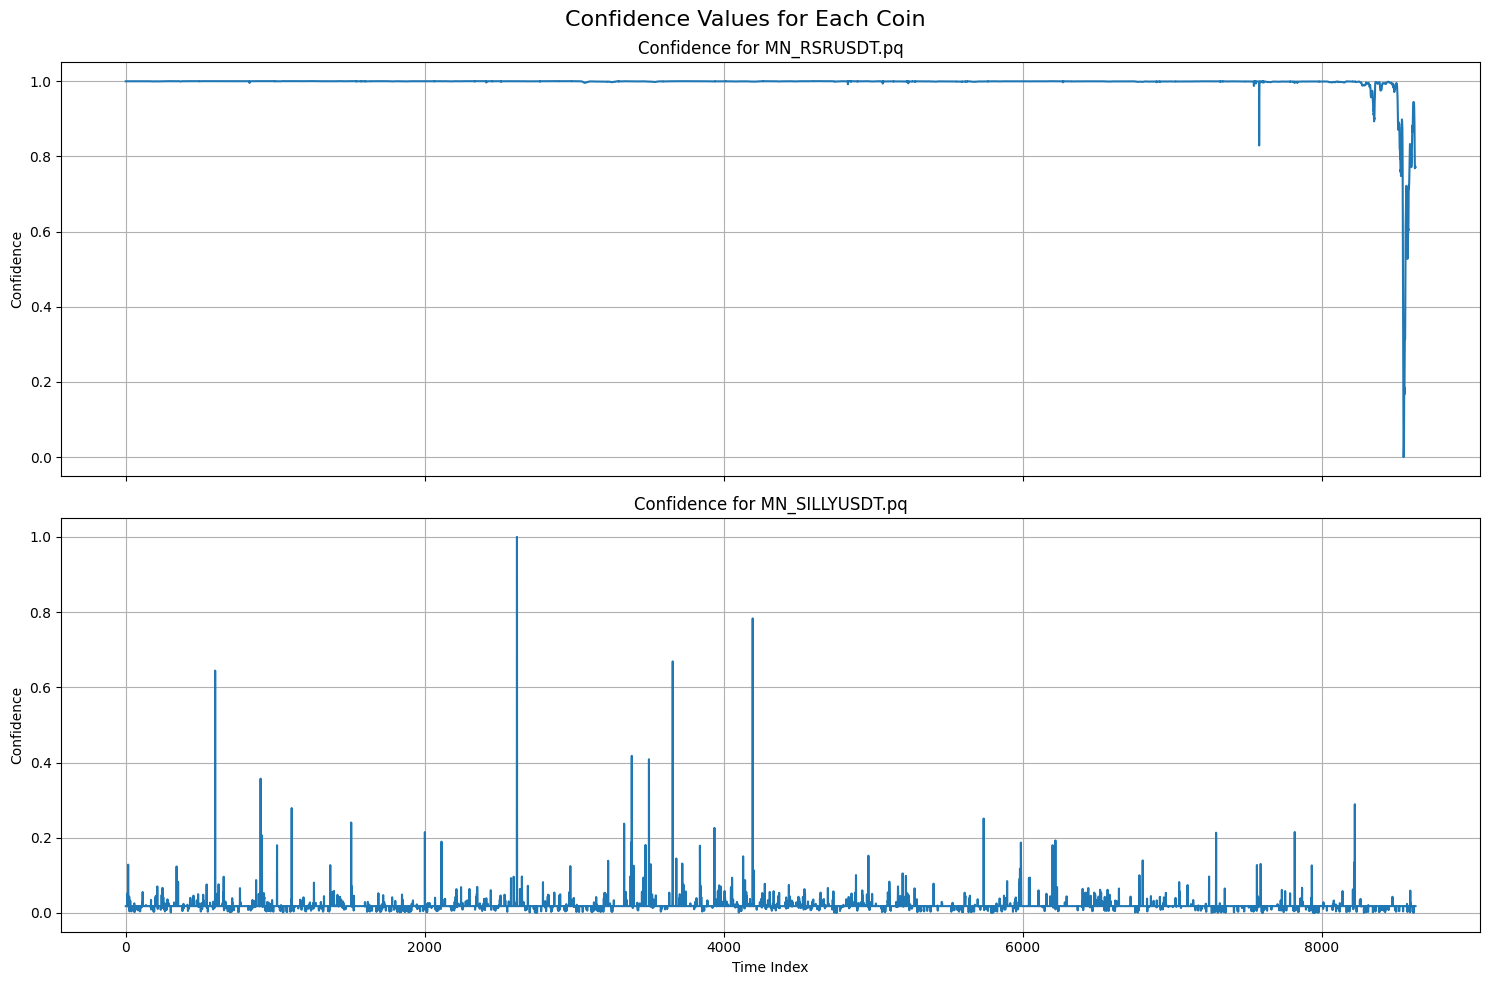


Confidence Statistics:
       MN_RSRUSDT.pq  MN_SILLYUSDT.pq
count    8629.000000      8629.000000
mean        0.994913         0.019930
std         0.043950         0.022201
min         0.000000         0.000000
25%         0.999119         0.018082
50%         0.999494         0.018082
75%         0.999743         0.018082
max         1.000000         1.000000


In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a list of timestamps corresponding to your confidence values
# If not, we'll create a range of indices

# Convert confidences_linear to a DataFrame for easier plotting
conf_df = pd.DataFrame(confidences_linear)

# Create a figure with subplots for each coin
n_coins = len(confidences_linear)
fig, axes = plt.subplots(n_coins, 1, figsize=(15, 5*n_coins), sharex=True)
fig.suptitle('Confidence Values for Each Coin', fontsize=16)

# If there's only one coin, axes will not be an array, so we convert it to a list
if n_coins == 1:
    axes = [axes]

for (coin, confidences), ax in zip(confidences_linear.items(), axes):
    ax.plot(conf_df.index, conf_df[coin])
    ax.set_title(f'Confidence for {coin}')
    ax.set_ylabel('Confidence')
    ax.grid(True)

# Set the x-label only for the bottom subplot
axes[-1].set_xlabel('Time Index')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Additionally, let's print some statistics for each coin's confidences
print("\nConfidence Statistics:")
print(conf_df.describe())


Linear Preds:
Total Return: 91.50082777797044
Sharpe Ratio: 0.5279257823057553
Max Drawdown: 79.20709077002543
PNL Ratio (Money Earned / Money Spent): -0.0003134829906521494


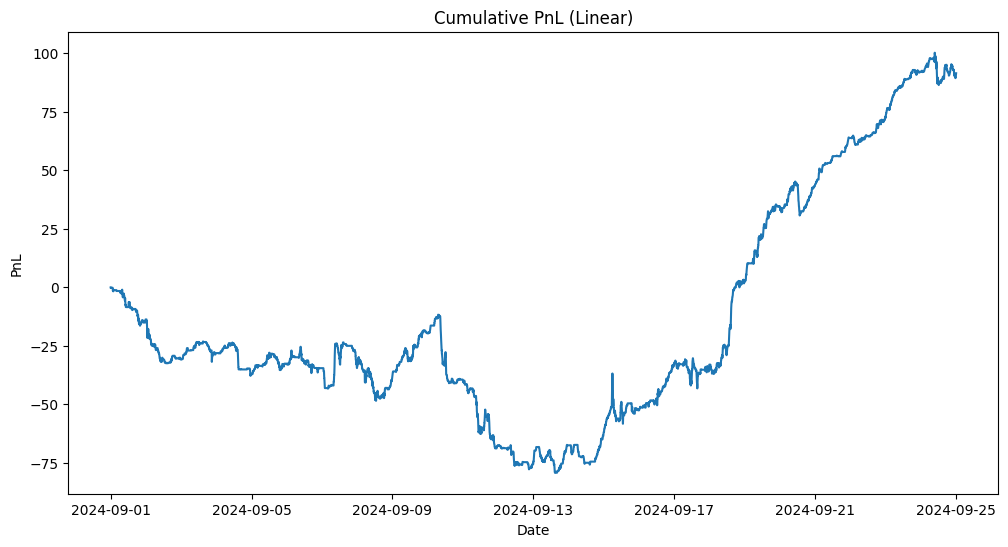

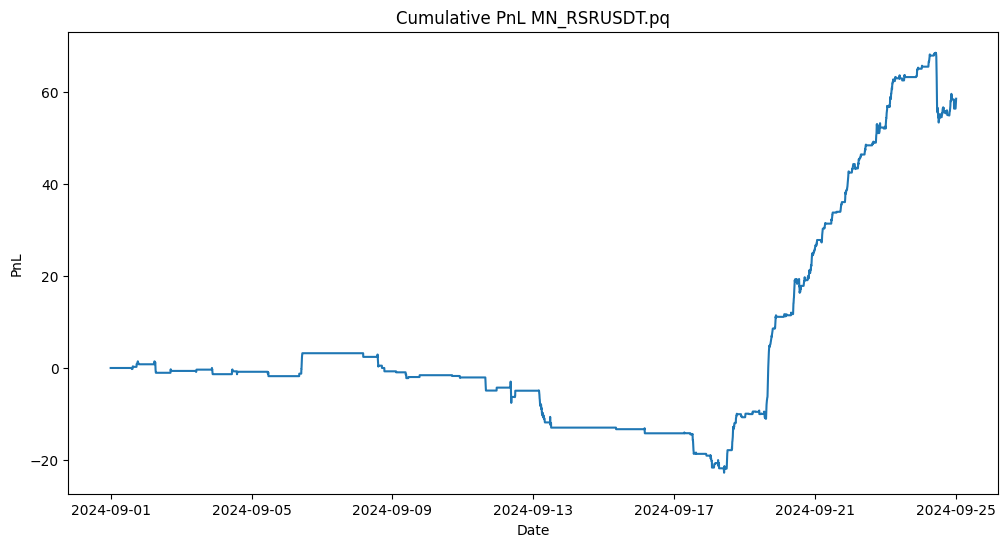

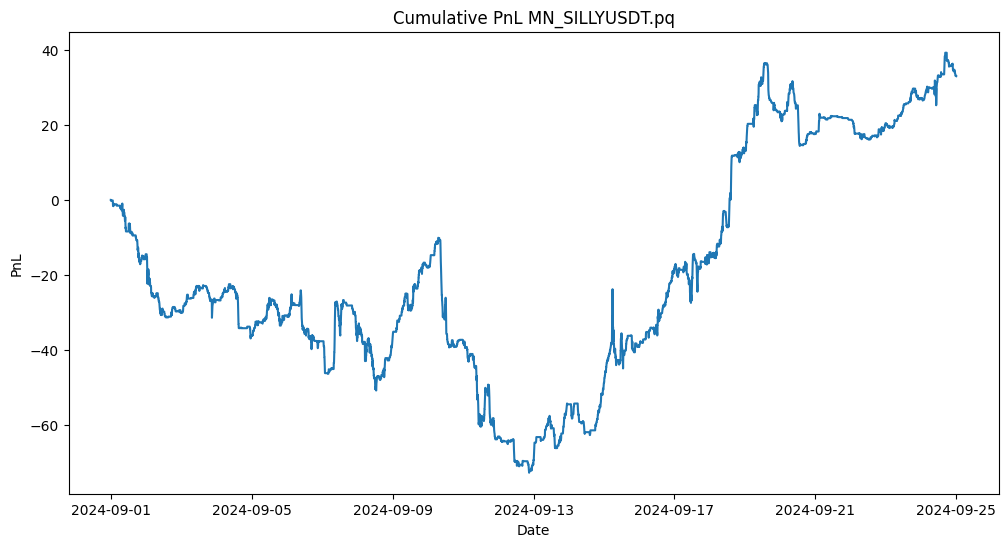


Cumulative PNL for each coin:
MN_RSRUSDT.pq: 58.5031
MN_SILLYUSDT.pq: 32.9977


In [18]:
def backtest_multi_coin_strategy(predictions_dict, confidence_dict, balance = 100, data_path='data/', market_neutral_path = "market_neutral/", train_time=None, returnInterval=12, spread=0.00175, test_times=[]):
    # Load market neutral data for all coins
    coin_data_mn = {}
    for coin in predictions_dict.keys():
        df = pd.read_parquet(f"{market_neutral_path}{coin}")
        df.set_index('time', inplace=True)
        df = df.sort_index()
        coin_data_mn[coin] = df

    # Calculate returns distribution for each coin before train_time
    returns_std = {}
    for coin, df in coin_data_mn.items():
        pre_train_returns = df[df.index < train_time]['mn_return']
        returns_std[coin] = np.std(pre_train_returns)

    # Load non-market neutral data for transaction cost calculation
    coin_data = {}
    for coin in predictions_dict.keys():
        df = pd.read_parquet(f"{data_path}{coin[3:]}")
        df.set_index('time', inplace=True)
        df = df.sort_index()
        coin_data[coin] = df
    
    btc_df = pd.read_parquet(f"{data_path}BTCUSDT.pq")
    btc_df.set_index('time', inplace=True)
    btc_df = btc_df.sort_index()

    # Prepare combined DataFrame for backtesting
    combined_df = pd.DataFrame()
    for coin, df in coin_data_mn.items():
        combined_df[f'{coin}_mn_close'] = df['mn_close']
        combined_df[f'{coin}_close'] = df['close']
        combined_df[f'{coin}_next_change'] = df['mn_close'].shift(-1) - df['mn_close']
    combined_df['BTC_close'] = btc_df['close']

    # Filter data after train_time
    if len(test_times) > 0:
        combined_df = combined_df.loc[test_times]
    else:
        combined_df[combined_df.index >= train_time]

    betas = {}
    for coin in predictions_dict.keys():
        betas[coin] = (combined_df[f'{coin}_close'] - combined_df[f'{coin}_mn_close']) / combined_df['BTC_close']

    # Add predictions and confidence values to combined_df
    for coin, preds in predictions_dict.items():
        combined_df[f'{coin}_pred'] = preds
        if confidence_dict != None:
            combined_df[f'{coin}_confidence'] = confidence_dict[coin]

    # Calculate signals and positions
    for coin in predictions_dict.keys():
        if confidence_dict != None:
            combined_df[f'{coin}_signal'] = combined_df[f'{coin}_pred'] / returns_std[coin]
        else:
            combined_df[f'{coin}_signal'] = combined_df[f'{coin}_pred'] / returns_std[coin]
        
        # Set position to 0 if abs(predicted return) <= spread
        combined_df[f'{coin}_position'] = np.where(
            np.abs(combined_df[f'{coin}_pred']) <= spread,
            0,
            combined_df[f'{coin}_signal']
        )

    # Normalize positions to ensure sum of absolute values doesn't exceed 1
    position_columns = [f'{coin}_position' for coin in predictions_dict.keys()]
    combined_df['total_position'] = combined_df[position_columns].abs().sum(axis=1)
    for coin in predictions_dict.keys():
        combined_df[f'{coin}_position'] = np.where(
            combined_df['total_position'] > 0,
            combined_df[f'{coin}_position'] / combined_df['total_position'],
            0
        )

   
    # Calculate PnL for each coin
    total_money_spent = 0
    total_money_earned = 0
    coin_cumulative_pnl = {}

    combined_df = combined_df[combined_df.index <= "09/25/2024"]
    for coin in predictions_dict.keys():
        close_price = combined_df[f'{coin}_close']
        btc_close_price = combined_df[f'BTC_close']
        position = combined_df[f'{coin}_position']
        next_change = combined_df[f'{coin}_next_change']
        
        # Calculate trade amount in dollars
        trade_amount = position * (balance)  # Assuming $1 total investment
        
        # Calculate number of coins traded
        # Calculate number of coins traded, limited to 100
        num_coins = np.abs(trade_amount / (close_price + betas[coin] * btc_close_price))
        num_coins = np.sign(trade_amount) * num_coins  # Preserve the sign
        
        # Recalculate trade amount based on limited number of coins
        # trade_amount = num_coins * close_price
        # print(min(abs(close_price)))
        
        # Calculate money spent and earned
        money_spent = trade_amount
        money_earned = num_coins * next_change
        
        total_money_spent += money_spent.sum()
        total_money_earned += money_earned.sum()
        
        # Calculate PnL
        coin_pnl = money_earned - spread * money_spent
        # print(max(coin_pnl))
        combined_df[f'{coin}_pnl'] = coin_pnl
        combined_df[f'{coin}_cumulative_pnl'] = coin_pnl.cumsum()
        # print(max(coin_pnl))
        # Store the final cumulative PNL for each coin
        coin_cumulative_pnl[coin] = combined_df[f'{coin}_cumulative_pnl'].iloc[-1]
        
    # Calculate total and cumulative PnL
    combined_df['total_pnl'] = combined_df[[f'{coin}_pnl' for coin in predictions_dict.keys()]].sum(axis=1)
    combined_df['cumulative_pnl'] = combined_df['total_pnl'].cumsum()

    # print(coin_cumulative_pnl)
    # Calculate PNL ratio
    pnl_ratio = total_money_earned / total_money_spent if total_money_spent != 0 else 0

    # Calculate additional metrics
    total_return = combined_df['cumulative_pnl'].iloc[-1]
    sharpe_ratio = np.sqrt(365) * combined_df['total_pnl'].mean() / combined_df['total_pnl'].std()
    max_drawdown = (combined_df['cumulative_pnl'].cummax() - combined_df['cumulative_pnl']).max()

    return combined_df, total_return, sharpe_ratio, max_drawdown, pnl_ratio, coin_cumulative_pnl

# Example usage:
train_time = pd.to_datetime("09/01/24")

print("Linear Preds:")
results_df, total_return, sharpe_ratio, max_drawdown, pnl_ratio, coin_cumulative_pnl = backtest_multi_coin_strategy(predictions_linear, confidences_linear, train_time=train_time, test_times = times[0])
print(f"Total Return: {total_return}")
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Drawdown: {max_drawdown}")
print(f"PNL Ratio (Money Earned / Money Spent): {pnl_ratio}")

# results_df = results_df[results_df.index <= "09/25/2024"]
# Plot cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['cumulative_pnl'])
plt.title('Cumulative PnL (Linear)')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.show()

for key in coin_cumulative_pnl.keys():
    plt.figure(figsize=(12, 6))
    plt.plot(results_df.index, results_df[f'{key}_cumulative_pnl'])
    plt.title(f'Cumulative PnL {key}')
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.show()



# Print cumulative PNL for each coin
print("\nCumulative PNL for each coin:")
for coin, pnl in coin_cumulative_pnl.items():
    print(f"{coin}: {pnl:.4f}")